In [3]:
import pandas as pd

train_df = pd.read_csv('datasets/digit/train.csv')
predict_df = pd.read_csv('datasets/digit/test.csv')

In [67]:
from sklearn.model_selection import train_test_split
import numpy as np

def blur(data):
    blur_data = []
    for d in data.reshape((data.shape[0], 28, 28)):
        blur_data.append(cv2.GaussianBlur(d,(5,5),0))
    bd = np.array(blur_data)
    return np.multiply(bd.reshape((data.shape[0], 784)), 1.0 / 255.0)
        
train_labels = train_df['label'].values
# train_images = train_df.drop('label',axis=1).values.reshape((train_df.shape[0], 28, 28))

#train_images = train_df.drop('label',axis=1).values.astype(np.float)
#train_images = np.multiply(train_images, 1.0 / 255.0)
train_images = blur(train_df.drop('label',axis=1).values.astype(np.float))

X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, random_state=42)


#predict_images = predict_df.values.astype(np.float)
#predict_images = np.multiply(predict_images, 1.0 / 255.0)

predict_images = blur(predict_df.values.astype(np.float))

In [48]:
import cv2

X_train_process = []
y_train_process = []

#print(y_train)
X_test = np.multiply(X_test, 1.0 / 255.0)

for i in range(len(X_train)):
    img = X_train[i]
    label = y_train[i]
    X_train_process.append(img)
    y_train_process.append(label)

    m = cv2.getRotationMatrix2D((14,14), 45, 1.0)
    rotated = cv2.warpAffine(img.reshape((28, 28)).astype(np.float), m, (28, 28))
    X_train_process.append(rotated.reshape(784))
    y_train_process.append(label)

#    m = cv2.getRotationMatrix2D((14,14), -45, 1.0)
#    rotated = cv2.warpAffine(img.reshape((28, 28)).astype(np.float), m, (28, 28))
#    X_train_process.append(rotated.reshape(784))
#    y_train_process.append(label)

X_train_p = np.array(X_train_process)
y_train_p = np.array(y_train_process)

X_train_p = np.multiply(X_train_p, 1.0 / 255.0)

In [23]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=10000).fit(X_train, y_train)

print("Training set score : {:.3f}".format(lr.score(X_train, y_train)))
print("Test set score : {:.3f}".format(lr.score(X_test, y_test)))

predictions = lr.predict(predict_images)

Training set score : 0.946
Test set score : 0.920


In [69]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='lbfgs', max_iter=1000, activation='tanh', alpha=5,
                    hidden_layer_sizes=[100, 100], random_state=42)
mlp.fit(X_train, y_train)

print("Training set score : {:.3f}".format(mlp.score(X_train, y_train)))
print("Test set score : {:.3f}".format(mlp.score(X_test, y_test)))

predictions = mlp.predict(predict_images)

Training set score : 1.000
Test set score : 0.978


In [70]:
out = { 'ImageId': [ i for i in range(1, len(predictions) + 1)], 'Label': predictions }
out_df = pd.DataFrame(out)
out_df.to_csv('/tmp/submission-digit.csv', encoding='utf-8', index=False)

In [5]:
process_images = train_df.drop('label',axis=1).values.reshape((train_df.shape[0], 28, 28))
print(process_images.shape)

(42000, 28, 28)


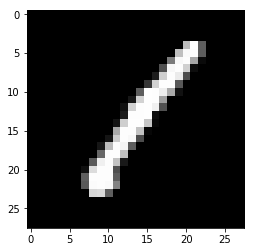

In [52]:
from matplotlib import pyplot as plt
import cv2

img = process_images[0]
plt.imshow(img, cmap='gray')
plt.show()

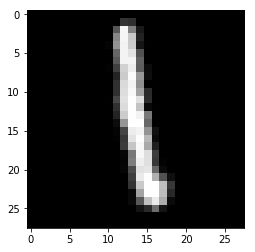

In [54]:
M = cv2.getRotationMatrix2D((14,14), 45, 1.0)
rotated = cv2.warpAffine(img.astype(np.float), M, (28, 28))
#print(rotated.reshape(784))

plt.imshow(rotated, cmap='gray')
plt.show()

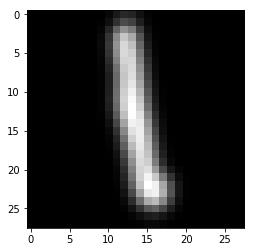

In [55]:
blur = cv2.GaussianBlur(rotated,(5,5),0)
plt.imshow(blur, cmap='gray')
plt.show()